# Purposes of this document



# Experimental setup related to the questions

this part should be configured to directly test the hypothesis put forward in the previous section


In [1]:
import numpy as np

#encoder mean firing rate
neuron_firing_rate = 100

#setting clda parameters 
##learner: collects paird data at batch_sizes

RHO = 0.5
batch_sizes = np.array([10, 20, 40, 80, 160, 320, 640])

#for comparision
exp_conds = [f'batch size:{b} samples' for b in batch_sizes]
print(exp_conds)

#assistor set up assist level
assist_level = (0.05, 0.0)

#learner and updater: actualy set up rho
UPDATER_BATCH_TIME = 1
UPDATER_HALF_LIFE = np.log(RHO)  * UPDATER_BATCH_TIME / np.log(0.5)


['batch size:10 samples', 'batch size:20 samples', 'batch size:40 samples', 'batch size:80 samples', 'batch size:160 samples', 'batch size:320 samples', 'batch size:640 samples']


In [2]:
# CHANGE: game mechanics: generate task params
N_TARGETS = 8
N_TRIALS = 80

NUM_EXP = len(exp_conds) # how many experiments we are running. 

# setting up the simulation components

this section largely copyied and pasted from   
bmi3d-sijia(branch)-bulti_in_experiemnts
https://github.com/sijia66/brain-python-interface/blob/master/built_in_tasks/sim_task_KF.py

In [3]:
# import libraries
# make sure these directories are in the python path., 
from bmimultitasks import SimBMIControlMulti, SimBMICosEncKFDec, BMIControlMultiNoWindow
from features import SaveHDF
from features.simulation_features import get_enc_setup, SimKFDecoderRandom, SimCosineTunedEnc,SimIntentionLQRController, SimClockTick
from features.simulation_features import SimHDF, SimTime

from riglib import experiment

from riglib.stereo_opengl.window import FakeWindow
from riglib.bmi import train

from behaviour_metrics import calc_inter_wait_times,filter_state, sort_trials


import weights

import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import itertools #for identical sequences

np.set_printoptions(precision=2, suppress=True)


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/blackrock/cerelink.py:13: UserWarning: Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system
  warnings.warn("Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system")


## Define Global Plotting variables

In [40]:
GLOBAL_FIGURE_VERTICAL_SIZE = 4
print(f'we define vertical screen size {GLOBAL_FIGURE_VERTICAL_SIZE}')

we define vertical screen size 4


##  behaviour and task setup

In [4]:
seq = SimBMIControlMulti.sim_target_seq_generator_multi(
N_TARGETS, N_TRIALS)

#create a second version of the tasks
seqs = itertools.tee(seq, NUM_EXP + 1)
target_seq = list(seqs[NUM_EXP])

seqs = seqs[:NUM_EXP]


SAVE_HDF = False
SAVE_SIM_HDF = True #this makes the task data available as exp.task_data_hist
DEBUG_FEATURE = False


#base_class = SimBMIControlMulti
base_class = BMIControlMultiNoWindow

#for adding experimental features such as encoder, decoder
feats = []

## encoder

the cosine tuned encoder uses a poisson process, right
https://en.wikipedia.org/wiki/Poisson_distribution
so if the lambda is 1, then it's very likely 

In [5]:
ENCODER_TYPE = 'cosine_tuned_encoder'

#neuron set up : 'std (20 neurons)' or 'toy (4 neurons)' 
N_NEURONS, N_STATES, sim_C = get_enc_setup(sim_mode = 'toy')


#actually multiply out the firing rates. 
sim_C_all = sim_C * neuron_firing_rate


#set up intention feedbackcontroller
#this ideally set before the encoder
feats.append(SimIntentionLQRController)

#set up the encoder
if ENCODER_TYPE == 'cosine_tuned_encoder' :
    feats.append(SimCosineTunedEnc)
    print(f'{__name__}: selected SimCosineTunedEnc\n')

features.simulation_features: get_enc_setup has a tuning_level of 1 

__main__: selected SimCosineTunedEnc



## decoder setup

In [6]:
#clda on random 
DECODER_MODE = 'random' # random 

   #take care the decoder setup
if DECODER_MODE == 'random':
    feats.append(SimKFDecoderRandom)
    print(f'{__name__}: set base class ')
    print(f'{__name__}: selected SimKFDecoderRandom \n')
else: #defaul to a cosEnc and a pre-traind KF DEC
    from features.simulation_features import SimKFDecoderSup
    feats.append(SimKFDecoderSup)
    print(f'{__name__}: set decoder to SimKFDecoderSup\n')

__main__: set base class 
__main__: selected SimKFDecoderRandom 



##  clda: learner and updater

In [7]:


LEARNER_TYPE = 'feedback' # to dumb or not dumb it is a question 'feedback'
UPDATER_TYPE = 'smooth_batch' #none or "smooth_batch"


#you know what? 
#learner only collects firing rates labeled with estimated estimates
#we would also need to use the labeled data
#now, we can set up a dumb/or not-dumb learner
if LEARNER_TYPE == 'feedback':
    from features.simulation_features import SimFeedbackLearner
    feats.append(SimFeedbackLearner)
else:
    from features.simulation_features import SimDumbLearner
    feats.append(SimDumbLearner)

#to update the decoder.
if UPDATER_TYPE == 'smooth_batch':
    from features.simulation_features import SimSmoothBatch
    feats.append(SimSmoothBatch)
else: #defaut to none 
    print(f'{__name__}: need to specify an updater')
    



## assistor setup

## (Check) config the experiment

In [8]:
if DEBUG_FEATURE: 
    from features.simulation_features import DebugFeature
    feats.append(DebugFeature)
    
if SAVE_HDF: feats.append(SaveHDF)
if SAVE_SIM_HDF: feats.append(SimHDF)
    
    
#pass the real time limit on clock
feats.append(SimClockTick)
feats.append(SimTime)


kwargs_exps = list()

for i in range(NUM_EXP):
    d = dict()
    
    d['assist_level'] = assist_level
    d['sim_C'] = sim_C_all
    d['batch_size'] = batch_sizes[i]
    
    d['batch_time'] = UPDATER_BATCH_TIME
    d['half_life'] = UPDATER_HALF_LIFE
    
    kwargs_exps.append(d)


kwargs_exps

[{'assist_level': (0.05, 0.0),
  'sim_C': array([[   0.,    0.,    0.,  100.,    0.,    0.,    0.],
         [   0.,    0.,    0., -100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
         [   0.,    0.,    0.,    0.,    0., -100.,    0.]]),
  'batch_size': 10,
  'batch_time': 1,
  'half_life': 1.0},
 {'assist_level': (0.05, 0.0),
  'sim_C': array([[   0.,    0.,    0.,  100.,    0.,    0.,    0.],
         [   0.,    0.,    0., -100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
         [   0.,    0.,    0.,    0.,    0., -100.,    0.]]),
  'batch_size': 20,
  'batch_time': 1,
  'half_life': 1.0},
 {'assist_level': (0.05, 0.0),
  'sim_C': array([[   0.,    0.,    0.,  100.,    0.,    0.,    0.],
         [   0.,    0.,    0., -100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
         [   0.,    0.,    0.,    0.,    0., -100.,    0.]]),
  'batch_size': 40,
  'batch_time'

## make and initalize experiment instances

In [9]:
#seed the experiment
np.random.seed(0)

#spawn the task
Exp = experiment.make(base_class, feats=feats)

exps = list()#create a list of experiment

for i,s in enumerate(seqs):
    e = Exp(s, **kwargs_exps[i])
    exps.append(e)

#run the ini
for e in exps: e.init()

metaclass constructor
(<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>, <class 'bmimultitasks.BMIControlMultiNoWindow'>)
[<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>]

features.simulation_features.SimInte

# Pre-experiment check: check the Kalman filter before training

we replace the encoder using the weights
assume, they are all randomly initialized get the first decoder
get a handle to the first decoder
we check the new decoder C matrix:


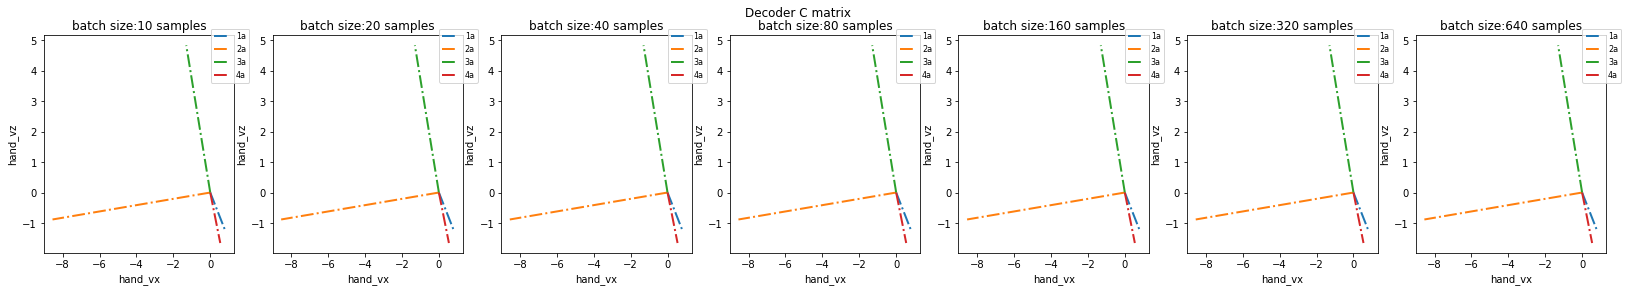

In [42]:
print('we replace the encoder using the weights')
print('assume, they are all randomly initialized get the first decoder')
print('get a handle to the first decoder')
first_decoder = exps[0].decoder
target_C = first_decoder.filt.C
    
#replace the decoder
for i,e in enumerate(exps):
    weights.change_target_kalman_filter_with_a_C_mat(e.decoder.filt, target_C, debug=False)
    
print('we check the new decoder C matrix:')

decoder_c_figure, axs = plt.subplots(nrows=1, 
                               ncols=NUM_EXP, figsize = [GLOBAL_FIGURE_VERTICAL_SIZE * NUM_EXP, GLOBAL_FIGURE_VERTICAL_SIZE])
decoder_c_figure.suptitle('Decoder C matrix ')

for i,e in enumerate(exps):
    e.decoder.plot_C(ax = axs[i])
    axs[i].set_title(exp_conds[i])

# Experiment run: assemble into a complete loop

##  define the function

In [11]:
#make this into a loop

def run_exp_loop(exp,  **kwargs):
        # riglib.experiment: line 597 - 601
    #exp.next_trial = next(exp.gen)
    # -+exp._parse_next_trial()np.arraynp.array


    # we need to set the initial state
    # per fsm.run:  line 138


    # Initialize the FSM before the loop
    exp.set_state(exp.state)
    
    finished_trials = exp.calc_state_occurrences('wait')
    print(f'finished: {finished_trials}')


    while exp.state is not None:

        # exp.fsm_tick()

        ### Execute commands#####
        exp.exec_state_specific_actions(exp.state)

        ###run the bmi loop #####
        # _cycle

        # bmi feature extraction, eh
        #riglib.bmi: 1202
        feature_data = exp.get_features()

        # Determine the target_state and save to file
        current_assist_level = exp.get_current_assist_level()
        target_state = exp.get_target_BMI_state(exp.decoder.states)

        # Determine the assistive control inputs to the Decoder
        #update assistive control level
        exp.update_level()
        if np.any(current_assist_level) > 0:
            current_state = exp.get_current_state()

            if target_state.shape[1] > 1:
                assist_kwargs = exp.assister(current_state, 
                                             target_state[:,0].reshape(-1,1), 
                                             current_assist_level, mode= exp.state)
            else:
                assist_kwargs = exp.assister(current_state, 
                                              target_state, 
                                              current_assist_level, 
                                              mode= exp.state)

            kwargs.update(assist_kwargs)
            
        

        # decode the new features
        # riglib.bmi.bmiloop: line 1245
        neural_features = feature_data[exp.extractor.feature_type]

        # call decoder.
        #tmp = exp.call_decoder(neural_features, target_state, **kwargs)
        neural_obs = neural_features
        learn_flag = exp.learn_flag
        task_state = exp.state

        n_units, n_obs = neural_obs.shape
        # If the target is specified as a 1D position, tile to match
        # the number of dimensions as the neural features
        if np.ndim(target_state) == 1 or (target_state.shape[1] == 1 and n_obs > 1):
            target_state = np.tile(target_state, [1, n_obs])

        decoded_states = np.zeros([exp.bmi_system.decoder.n_states, n_obs])
        update_flag = False

        for k in range(n_obs):
            neural_obs_k = neural_obs[:, k].reshape(-1, 1)
            target_state_k = target_state[:, k]

            # NOTE: the conditional below is *only* for compatibility with older Carmena
            # lab data collected using a different MATLAB-based system. In all python cases,
            # the task_state should never contain NaN values.
            if np.any(np.isnan(target_state_k)):
                task_state = 'no_target'

            #################################
            # Decode the current observation
            #################################
            decodable_obs, decode = exp.bmi_system.feature_accumulator(
                neural_obs_k)
            if decode:  # if a new decodable observation is available from the feature accumulator
                prev_state = exp.bmi_system.decoder.get_state()

                exp.bmi_system.decoder(decodable_obs, **kwargs)
                # Determine whether the current state or previous state should be given to the learner
                if exp.bmi_system.learner.input_state_index == 0:
                    learner_state = exp.bmi_system.decoder.get_state()
                elif exp.bmi_system.learner.input_state_index == -1:
                    learner_state = prev_state
                else:
                    print(("Not implemented yet: %d" %
                           exp.bmi_system.learner.input_state_index))
                    learner_state = prev_state

                if learn_flag:
                    exp.bmi_system.learner(decodable_obs.copy(), learner_state, target_state_k, exp.bmi_system.decoder.get_state(
                    ), task_state, state_order=exp.bmi_system.decoder.ssm.state_order)

            decoded_states[:, k] = exp.bmi_system.decoder.get_state()

            ############################
            # Update decoder parameters
            ############################
            if exp.bmi_system.learner.is_ready():
                batch_data = exp.bmi_system.learner.get_batch()
                batch_data['decoder'] = exp.bmi_system.decoder
                kwargs.update(batch_data)
                exp.bmi_system.updater(**kwargs)
                exp.bmi_system.learner.disable()
                

            new_params = None  # by default, no new parameters are available
            if exp.bmi_system.has_updater:
                new_params = copy.deepcopy(exp.bmi_system.updater.get_result())
                
            
            # Update the decoder if new parameters are available
            if not (new_params is None):
                exp.bmi_system.decoder.update_params(
                    new_params, **exp.bmi_system.updater.update_kwargs)
                new_params['intended_kin'] = batch_data['intended_kin']
                new_params['spike_counts_batch'] = batch_data['spike_counts']

                exp.bmi_system.learner.enable()
                update_flag = True

                # Save new parameters to parameter history
                exp.bmi_system.param_hist.append(new_params)



        # saved as task data
        # return decoded_states, update_flag
        tmp = decoded_states
        exp.task_data['internal_decoder_state'] = tmp

        # reset the plant position
        # @riglib.bmi.BMILoop.move_plant  line:1254
        exp.plant.drive(exp.decoder)

        # check state transitions and run the FSM.
        current_state = exp.state

        # iterate over the possible events which could move the task out of the current state
        for event in exp.status[current_state]:
            # if the event has occurred
            if exp.test_state_transition_event(event):
                # execute commands to end the current state
                exp.end_state(current_state)

                # trigger the transition for the event
                exp.trigger_event(event)

                # stop searching for transition events (transition events must be
                # mutually exclusive for this FSM to function properly)
                break

        # sort out the loop params.
        # inc cycle count
        exp.cycle_count += 1

        # save target data as was done in manualControlTasks._cycle
        exp.task_data['target'] = exp.target_location.copy()
        exp.task_data['target_index'] = exp.target_index

        #done in bmi:_cycle after move_plant
        exp.task_data['loop_time'] = exp.iter_time()


        #fb_controller data
        exp.task_data['target_state'] = target_state

        #encoder data
        #input to this is actually extractor
        exp.task_data['ctrl_input'] = np.reshape(exp.extractor.sim_ctrl, (1,-1))

        #actually output
        exp.task_data['spike_counts'] = feature_data['spike_counts']


        #save the decoder_state
        #from BMILoop.move_plant
        exp.task_data['decoder_state'] = exp.decoder.get_state(shape=(-1,1))
        
        #save bmi_data
        exp.task_data['update_bmi'] = update_flag


        # as well as plant data.
        plant_data = exp.plant.get_data_to_save()
        for key in plant_data:
            exp.task_data[key] = plant_data[key]

        # clda data handled in the above call.

        # save to the list hisory of data.
        exp.task_data_hist.append(exp.task_data.copy())
        
        #print out the trial update whenever wait count changes, alright. 
        if finished_trials != exp.calc_state_occurrences('wait'):
            finished_trials = exp.calc_state_occurrences('wait')
            print(f'finished trials :{finished_trials} with a current assist level of {exp.get_current_assist_level()}')
        

    if exp.verbose:
        print("end of FSM.run, task state is", exp.state)
    
    


## actually running the experiments

In [12]:
for i,e in enumerate(exps):
    run_exp_loop(e, **kwargs_exps[i])
    print(f'Finished running  {exp_conds[i]}')
    print()

runseq
finished: 1
assist_level:  0.05
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :2 with a current assist level of 0.049600000000000005
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/bmi/kfdecoder.py:372: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C = np.mat(np.linalg.lstsq(X.T, Y.T)[0].T)


KFSmoothbatch: calculating new SB parameters
finished trials :3 with a current assist level of 0.04926666666666667
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :4 with a current assist level of 0.04891388888888889
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :5 with a current assist level of 0.048690277777777784
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculati

KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :30 with a current assist level of 0.0371
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :31 with a current assist level of 0.03669861111111111
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :32 with a current assist level of 0.03635
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :33 with a current assist level of 0.03600833333333334
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calcul

KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :54 with a current assist level of 0.02471527777777778
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
observations have counts >> 1000 
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :55 with a current assis

finished trials :76 with a current assist level of 0.012805555555555563
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :77 with a current assist level of 0.012256944444444445
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :78 with a current assist level of 0.011940277777777779
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :79 with a current assist level of 0.01164861111111111
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB para

KFSmoothbatch: calculating new SB parameters
assist_level:  0.035
finished trials :41 with a current assist level of 0.03496666666666667
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :42 with a current assist level of 0.03457361111111111
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :43 with a current assist level of 0.034175
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :44 with a current assist level of 0.033898611111111115
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :45 with a current assist level of 0.03362222222222222
KFSmoothbatch: calculating new SB parameters
finished trials :46 with a current assist level of 0.03334166666666667
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
finished trials :47 wit

finished trials :13 with a current assist level of 0.04634861111111111
KFSmoothbatch: calculating new SB parameters
finished trials :14 with a current assist level of 0.04613055555555556
KFSmoothbatch: calculating new SB parameters
finished trials :15 with a current assist level of 0.045922222222222225
finished trials :16 with a current assist level of 0.045713888888888894
KFSmoothbatch: calculating new SB parameters
finished trials :17 with a current assist level of 0.045498611111111115
KFSmoothbatch: calculating new SB parameters
finished trials :18 with a current assist level of 0.045290277777777777
finished trials :19 with a current assist level of 0.04506527777777778
KFSmoothbatch: calculating new SB parameters
assist_level:  0.045
finished trials :20 with a current assist level of 0.04485694444444445
KFSmoothbatch: calculating new SB parameters
finished trials :21 with a current assist level of 0.044625000000000005
finished trials :22 with a current assist level of 0.044405555555

finished trials :14 with a current assist level of 0.045831944444444446
finished trials :15 with a current assist level of 0.045623611111111115
finished trials :16 with a current assist level of 0.045408333333333335
KFSmoothbatch: calculating new SB parameters
finished trials :17 with a current assist level of 0.04519027777777778
assist_level:  0.045
finished trials :18 with a current assist level of 0.044991666666666666
finished trials :19 with a current assist level of 0.044783333333333335
KFSmoothbatch: calculating new SB parameters
finished trials :20 with a current assist level of 0.044583333333333336
finished trials :21 with a current assist level of 0.04435833333333333
finished trials :22 with a current assist level of 0.04414166666666667
KFSmoothbatch: calculating new SB parameters
finished trials :23 with a current assist level of 0.043916666666666666
finished trials :24 with a current assist level of 0.04369722222222223
finished trials :25 with a current assist level of 0.043

finished trials :34 with a current assist level of 0.03959027777777778
finished trials :35 with a current assist level of 0.039375
KFSmoothbatch: calculating new SB parameters
finished trials :36 with a current assist level of 0.03916388888888889
finished trials :37 with a current assist level of 0.038948611111111114
finished trials :38 with a current assist level of 0.038725
finished trials :39 with a current assist level of 0.038497222222222224
finished trials :40 with a current assist level of 0.038281944444444445
finished trials :41 with a current assist level of 0.03806527777777778
KFSmoothbatch: calculating new SB parameters
finished trials :42 with a current assist level of 0.03785
finished trials :43 with a current assist level of 0.03764861111111111
finished trials :44 with a current assist level of 0.03744027777777778
finished trials :45 with a current assist level of 0.03723194444444445
finished trials :46 with a current assist level of 0.03701666666666667
finished trials :4

finished trials :63 with a current assist level of 0.031663888888888894
finished trials :64 with a current assist level of 0.031455555555555556
KFSmoothbatch: calculating new SB parameters
finished trials :65 with a current assist level of 0.031231944444444448
finished trials :66 with a current assist level of 0.031031944444444445
finished trials :67 with a current assist level of 0.03082361111111111
finished trials :68 with a current assist level of 0.030606944444444447
finished trials :69 with a current assist level of 0.03039027777777778
finished trials :70 with a current assist level of 0.030181944444444445
assist_level:  0.03
finished trials :71 with a current assist level of 0.029973611111111114
finished trials :72 with a current assist level of 0.02976527777777778
finished trials :73 with a current assist level of 0.02955
finished trials :74 with a current assist level of 0.02934166666666667
finished trials :75 with a current assist level of 0.029122222222222223
finished trials 

# Postprocessing the data for loading

In [13]:
for e in  exps: print(e.calc_state_occurrences('reward'))

80
80
80
80
80
80
79


## declare defs and conventions

In [14]:
FRAME_RATE = 60
INT_WINDOW_TIME = 10 # s for looking at sample raw data

# some conventions as we go down the loop
X_VEL_STATE_IND = 3
Y_VEL_STATE_IND = 5
X_POS_STATE_IND = 0
Y_POS_STATE_IND = 2

state_indices = [X_POS_STATE_IND,
                 Y_POS_STATE_IND,
                 X_VEL_STATE_IND,
                 Y_VEL_STATE_IND]
state_names = ['x pos ', 'y pos', 'x vel', 'y vel']


INT_WIN_SAMPLES = INT_WINDOW_TIME * FRAME_RATE



## Refactor out the data

In [15]:
task_data_hist_np_all = [np.array(e.task_data_hist) for e in exps]
task_data_hist_np_all[0].dtype

dtype([('cursor', '<f8', (3,)), ('obs_t', '<f8', (4, 1)), ('K', '<f8', (7, 4)), ('KC', '<f8', (7, 7)), ('pred_state_mean', '<f8', (7, 1)), ('post_state_mean', '<f8', (7, 1)), ('pred_state_P', '<f8', (7, 7)), ('post_state_P', '<f8', (7, 7)), ('loop_time', '<f8', (1,)), ('decoder_state', '<f8', (7, 1)), ('internal_decoder_state', '<f8', (7, 1)), ('target_state', '<f8', (7, 1)), ('update_bmi', '<f8', (1,)), ('spike_counts', '<f8', (4, 1)), ('bin_edges', '<f8', (2,)), ('ctrl_input', '<f8', (7,)), ('assist_level', '<f8', (1,)), ('target', '<f8', (3,)), ('target_index', '<i4', (1,))])

In [16]:
finished_times_in_seconds = [int(len(s)/FRAME_RATE) for s in task_data_hist_np_all]

finished_times_in_seconds

[468, 353, 236, 219, 243, 265, 356]

# Post data analysis

## Overall  trial statistics succuss rate)

In [17]:
state_logs = [e.state_log for e in exps]


In [18]:
STATE_CUT_NAME =  'wait'
#get the state logs
wait_logs = [filter_state(s, STATE_CUT_NAME) for s in state_logs]

inter_wait_times = [calc_inter_wait_times(w) for w in wait_logs]
#this has both start times 

Text(0, 0.5, 'Trial time (s)')

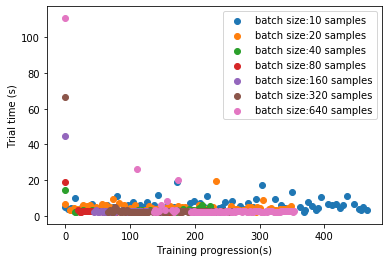

In [19]:


for i in inter_wait_times:
    plt.scatter(i[:,0], i[:,1])

plt.legend(exp_conds)
plt.xlabel('Training progression(s)')
plt.ylabel('Trial time (s)')

In [20]:
wait_time = inter_wait_times[0]
task_data_hist_np = task_data_hist_np_all[0]



In [21]:


trial_dicts_all = []
dict_keys = ['cursor', #behaviour
             'ctrl_input', 'spike_counts', #encoder translates intended ctrl into spike counts
             'decoder_state']

for i in range(NUM_EXP):
    wait_time = inter_wait_times[i]
    task_data_hist_np = task_data_hist_np_all[i]
    
    trial_dict_0 = sort_trials(wait_time, 
                               target_seq,
                               task_data_hist_np, dict_keys)
    
    trial_dicts_all.append(trial_dict_0)



In [22]:
print('finished times')

trial_dicts_all[0]

finished times


[{'cursor': array([[  0.  ,   0.  ,   0.  ],
         [  0.  ,   0.  ,   0.  ],
         [  0.  ,   0.  ,   0.  ],
         [  0.  ,   0.  ,   0.  ],
         [  0.  ,   0.  ,   0.  ],
         [  0.  ,   0.  ,   0.  ],
         [  0.  ,   0.  ,   0.  ],
         [  0.  ,   0.  ,   0.  ],
         [  0.  ,   0.  ,   0.  ],
         [  0.  ,   0.  ,   0.  ],
         [  0.  ,   0.  ,   0.  ],
         [ -0.01,   0.  ,  -0.02],
         [ -0.01,   0.  ,  -0.02],
         [ -0.01,   0.  ,  -0.02],
         [ -0.01,   0.  ,  -0.02],
         [ -0.01,   0.  ,  -0.02],
         [ -0.01,   0.  ,  -0.02],
         [  0.04,   0.  ,  -0.01],
         [  0.04,   0.  ,  -0.01],
         [  0.04,   0.  ,  -0.01],
         [  0.04,   0.  ,  -0.01],
         [  0.04,   0.  ,  -0.01],
         [  0.04,   0.  ,  -0.01],
         [  0.13,   0.  ,  -0.61],
         [  0.13,   0.  ,  -0.61],
         [  0.13,   0.  ,  -0.61],
         [  0.13,   0.  ,  -0.61],
         [  0.13,   0.  ,  -0.61],
         [

## Trajectory analysis

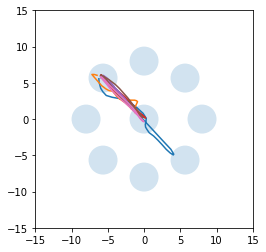

In [23]:
n_roi_trials = N_TRIALS - 1
unique_targets =  np.unique(target_seq, axis = 0)


X_CURSOR = 0
Z_CURSOR = 2
CIRCL_ALPHA = 0.2



RANGE_LIM =  15
figure, axes = plt.subplots() 

axes.set_xlim(-RANGE_LIM, RANGE_LIM)
axes.set_ylim(-RANGE_LIM, RANGE_LIM)

CIRCLE_RADIUS = exps[0].target_radius

#plot the targets

#plot the origin

cc = plt.Circle((0,0 ), 
            radius = CIRCLE_RADIUS,
            alpha = CIRCL_ALPHA)

axes.add_artist( cc ) 

for origin_t in unique_targets:
    origin = origin_t[0]
    t = origin_t[1]

    cc = plt.Circle((t[X_CURSOR],t[Z_CURSOR] ), 
                    radius = CIRCLE_RADIUS,
                    alpha = CIRCL_ALPHA)
                     
    axes.set_aspect( 1 ) 
    axes.add_artist( cc ) 
    
    
for trial_dict in trial_dicts_all:
    
    sample_trial = trial_dict[n_roi_trials]
    trial_cursor_trajectory = sample_trial['cursor']
    
    
    axes.plot(trial_cursor_trajectory[:, X_CURSOR], 
             trial_cursor_trajectory[:, Z_CURSOR])
    N_TRIALS = 80



In [24]:
print('finished trials:')

for i,e in  enumerate(exps): 
    reward_num = e.calc_state_occurrences('reward')
    print(f'{exp_conds[i]}: {reward_num} out of {N_TRIALS}')

finished trials:
batch size:10 samples: 80 out of 80
batch size:20 samples: 80 out of 80
batch size:40 samples: 80 out of 80
batch size:80 samples: 80 out of 80
batch size:160 samples: 80 out of 80
batch size:320 samples: 80 out of 80
batch size:640 samples: 79 out of 80


## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

In [26]:
n_exp = 0
spike_count_sample = trial_dicts_all[n_exp][n_roi_trials]['spike_counts']

## decoder

steady state tuning curves:


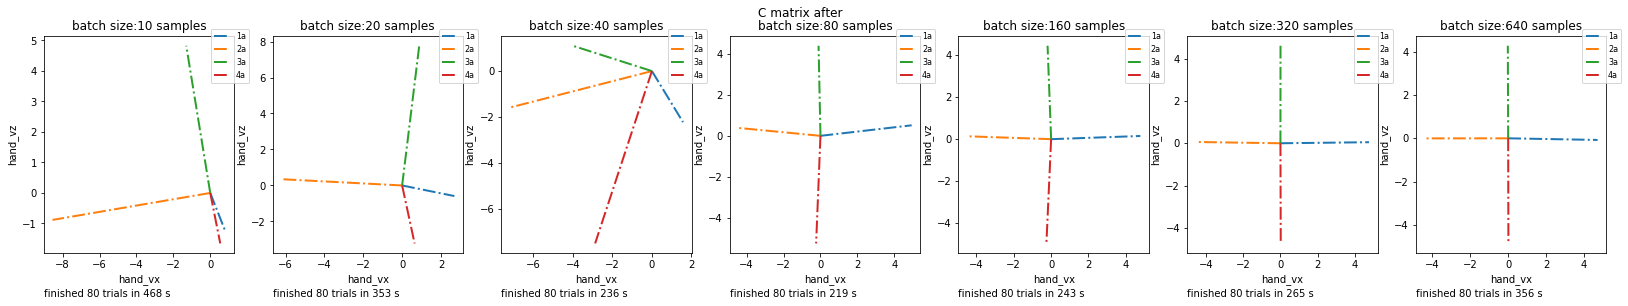

In [41]:

TEXT_OFFSET_VERTICAL = -0.2

decoder_c_after,axs = plt.subplots(1, NUM_EXP,
                                  figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * NUM_EXP, GLOBAL_FIGURE_VERTICAL_SIZE))

decoder_c_after.suptitle('C matrix after')

print('steady state tuning curves:')
for i,e in enumerate(exps):
    e.decoder.plot_C(ax = axs[i])
    axs[i].set_title(exp_conds[i])
    
    #get the lower left coordinate
    y_lim_range  = axs[i].get_ylim()[1] - axs[i].get_ylim()[0]
    
    axs[i].text(0, TEXT_OFFSET_VERTICAL,
                f'finished {N_TRIALS} trials in {finished_times_in_seconds[i]} s', 
               transform = axs[i].transAxes)

    



compare to before


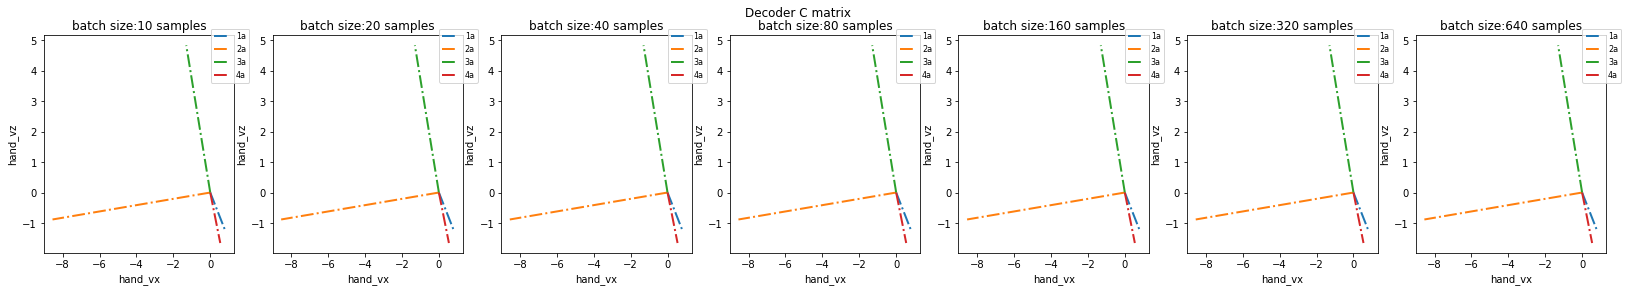

In [43]:
print('compare to before')

decoder_c_figure

## Decoder convergence

# CLDA updates

## clda update frequencies

In [54]:
clda_params_all = [np.array(e.bmi_system.param_hist) for e in exps]
n_bmi_updates = [len(c) for c in clda_params_all]

[468, 176, 59, 27, 15, 8, 5]

## reformat the matrix

In [32]:
clda_params = clda_params_all[0]

clda_params_dict_all = list()

for p in clda_params_all:
    clda_params_dict = dict()
    for param_key in p[0].keys():
        clda_params_dict[param_key] = np.array([ record_i[param_key] for record_i in p])
    
    clda_params_dict_all.append(clda_params_dict)


len(clda_params_dict_all)

7

## clda C matrix Analyzer

In [94]:
from convergence_analysis import ConvergenceAnalyzer as ca



optimal_matrix = exps[0].encoder.C
conv_norm_in_a_list = list()

for i in range(NUM_EXP):
    C = clda_params_dict_all[i]['kf.C']
    conv_norm = ca.calc_mse_along_rows(C, optimal)
    conv_norm_in_a_list.append(conv_norm)



In [83]:
optimal_matrix

array([[   0.,    0.,    0.,  100.,    0.,    0.,    0.],
       [   0.,    0.,    0., -100.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
       [   0.,    0.,    0.,    0.,    0., -100.,    0.]])

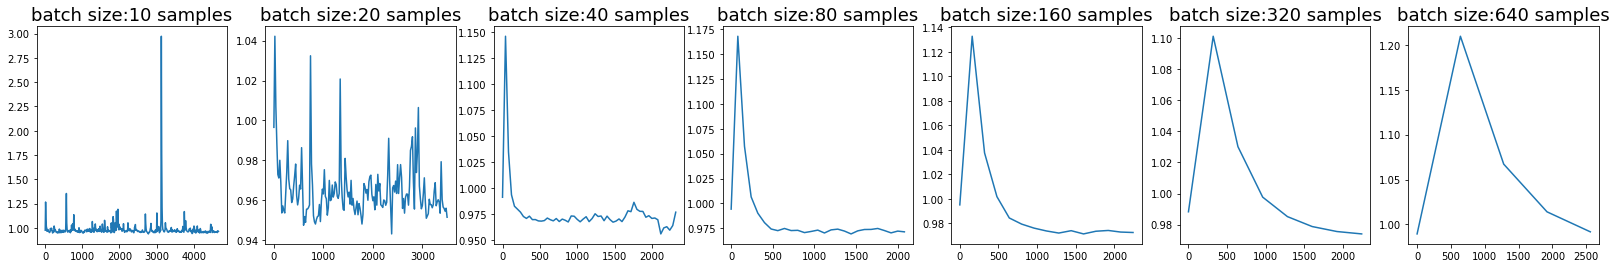

In [98]:
figure_frob_norm_conv_separate, axes_frob_conv_separate = plt.subplots(1, NUM_EXP,
                                                                      figsize = (NUM_EXP * GLOBAL_FIGURE_VERTICAL_SIZE, GLOBAL_FIGURE_VERTICAL_SIZE))

time_int = [np.arange(n) * batch_sizes[i] for i,n in enumerate(n_bmi_updates)]

for i in range(NUM_EXP):
    axes_frob_conv_separate[i].plot(time_int[i], conv_norm_in_a_list[i])
    axes_frob_conv_separate[i].set_title(exp_conds[i], fontsize = 18)
    

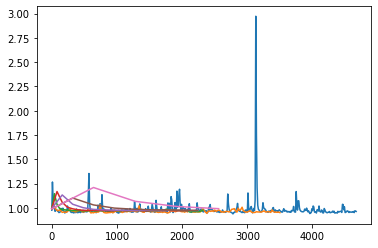

In [74]:
figure_frob_norm_conv, axes_frob_conv = plt.subplots()

for i in range(NUM_EXP):
    axes_frob_conv.plot(time_int[i], conv_norm_in_a_list[i])


(0.5, 1.5)

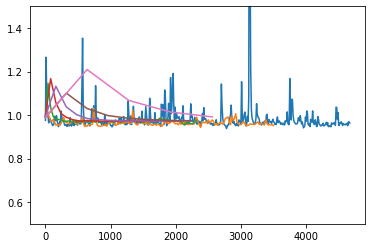

In [80]:
figure_frob_norm_conv_smaller, axes_frob_conv_smaller = plt.subplots()
X_UPPER_LIM = 1.5
X_LOWER_LIM = 0.5
for i in range(NUM_EXP):
    axes_frob_conv_smaller.plot(time_int[i], conv_norm_in_a_list[i])
    
axes_frob_conv_smaller.set_ylim([X_LOWER_LIM, X_UPPER_LIM])

In [68]:
ca.calc_mse_along_rows(optimal[np.newaxis,:,:], optimal)

array([0.])

In [69]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## CLDA compared to inital KF 

## CLDA C matrix analyzer with the initial

In [90]:
from convergence_analysis import ConvergenceAnalyzer as ca



initial_kalman_C = [c[0]['kf.C'] for c in clda_params_all]
conv_norm_comp_initial_in_a_list = list()

for i in range(NUM_EXP):
    C = clda_params_dict_all[i]['kf.C']
    conv_norm = ca.calc_mse_along_rows(C, initial_kalman_C[i])
    conv_norm_comp_initial_in_a_list.append(conv_norm)

[matrix([[ 0.  ,  0.  ,  0.  ,  6.88,  0.  ,  1.22,  3.18],
        [ 0.  ,  0.  ,  0.  ,  0.71,  0.  ,  2.26,  4.39],
        [ 0.  ,  0.  ,  0.  ,  1.1 ,  0.  ,  2.95,  4.73],
        [ 0.  ,  0.  ,  0.  ,  2.42,  0.  , -1.49,  8.88]]), matrix([[ 0.  ,  0.  ,  0.  ,  5.47,  0.  , -0.22, 15.19],
        [ 0.  ,  0.  ,  0.  , -0.64,  0.  ,  0.53, 17.2 ],
        [ 0.  ,  0.  ,  0.  , -0.28,  0.  ,  1.87, 24.77],
        [ 0.  ,  0.  ,  0.  ,  0.88,  0.  , -2.77, 26.26]]), matrix([[ 0.  ,  0.  ,  0.  ,  4.98,  0.  , -0.64, 13.58],
        [ 0.  ,  0.  ,  0.  , -0.94,  0.  ,  0.04, 15.38],
        [ 0.  ,  0.  ,  0.  ,  0.07,  0.  ,  2.48, 21.26],
        [ 0.  ,  0.  ,  0.  ,  1.44,  0.  , -2.  , 22.  ]]), matrix([[ 0.  ,  0.  ,  0.  ,  5.05,  0.  , -0.89, 13.36],
        [ 0.  ,  0.  ,  0.  , -0.97,  0.  , -0.07, 14.59],
        [ 0.  ,  0.  ,  0.  ,  0.09,  0.  ,  2.35, 23.96],
        [ 0.  ,  0.  ,  0.  ,  1.21,  0.  , -2.23, 25.68]]), matrix([[ 0.  ,  0.  ,  0.  ,  5.18,  0.  , -0.

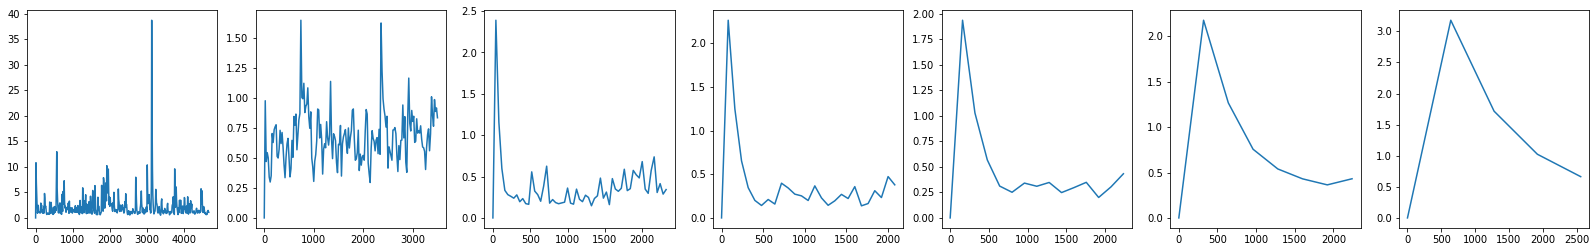

In [92]:
figure_frob_norm_conv_initial_separate, axes_frob_conv_initial_separate = plt.subplots(1, NUM_EXP,
                                                                      figsize = (NUM_EXP * GLOBAL_FIGURE_VERTICAL_SIZE, GLOBAL_FIGURE_VERTICAL_SIZE))

time_int = [np.arange(n) * batch_sizes[i] for i,n in enumerate(n_bmi_updates)]

for i in range(NUM_EXP):
    axes_frob_conv_initial_separate[i].plot(time_int[i], conv_norm_comp_initial_in_a_list[i])